# FastSLAM

REF : https://github.com/ryuichiueda/probrobo2017/blob/master/12.ipynb

In [1]:
# 数値計算に必要なモジュール
import numpy as np
from copy import copy
import math
import random

# 描画に必要なモジュール
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.rcParams.update({'figure.max_open_warning': 0}) #20枚以上画像を描画しても警告を出さないように設定

# ランドマークのクラス

ランドマーク描画用のクラスを用意します。

In [2]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([[x], [y]])
    def draw(self):
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
    def relative_pos(self, pose):
        x, y, theta = pose
        lx, ly = self.pos[0][0], self.pos[1][0]
        distance = math.sqrt((x - lx)**2 + (y - ly)**2)
        direction = math.atan2(ly - y, lx - x) - theta
        return (distance, direction, lx, ly)

# 地図のクラス

ランドマークを複数まとめて管理する地図のクラスを用意します。

In [3]:
class Map:
    def __init__(self):
        self.landmarks = []
    def append_landmark(self, x, y):
        self.landmarks.append(Landmark(x, y))
        
    def draw(self):
        xs = [ e.pos[0] for e in self.landmarks]
        ys = [ e.pos[1] for e in self.landmarks]
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
    
    def relative_landmark_positions(self, pose):
        positions = []
        for i, ln in enumerate(self.landmarks):
            distance, direction, lx, ly = ln.relative_pos(pose)
            positions.append([distance, direction, lx, ly, i])
        return positions

点ランドマークを3つ設置します。

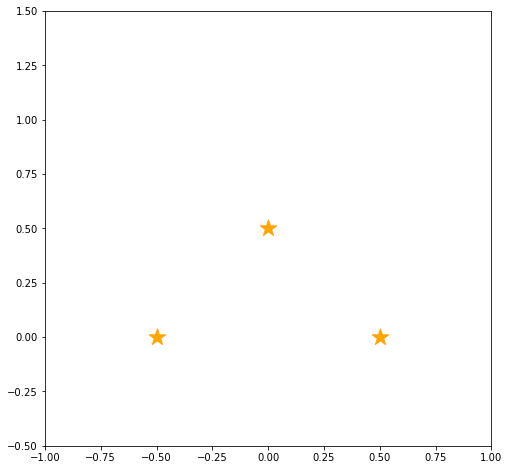

In [4]:
# 新規ウィンドウ、座標軸を用意
fig = plt.figure(figsize=(8, 8))
world = fig.add_subplot(1,1,1)
world.set_xlim(-1.0,1.0)
world.set_ylim(-0.5,1.5)

m = Map()
m.append_landmark(-0.5,0.0)
m.append_landmark(0.5,0.0)
m.append_landmark(0.0,0.5)

m.draw()
plt.show()

# ロボットとロボットのモーションのためのクラス

ロボットの姿勢の描画、ロボットの観測、ロボットのモーションを管理するクラスを作成します。

In [5]:
class Robot:
    def __init__(self, pose):
        self.pose = pose
        
    def draw(self):
        x, y, theta = self.pose
        plt.quiver([x], [y], [math.cos(theta)], [math.sin(theta)], color="red", label="actual robot motion")
    
    def observation(self, m):
        measurements = m.relative_landmark_positions(self.pose)
        observations = []
        for m in measurements:
            distance, direction, lx, ly, i = m
            if(math.cos(direction) < 0.0):
                continue
            measured_distance = random.gauss(distance, distance * 0.1)
            measured_direction = random.gauss(direction,5.0/180.0*math.pi)
            observations.append([measured_distance, measured_direction,lx,ly,i])  
        return observations
    
    def motion_model(self, pos, fw, rot):
        actual_fw = random.gauss(fw,fw/10)    #移動距離に雑音を入れておく。標準偏差:fwの10%
        dir_error = random.gauss(0.0, np.deg2rad(3.0)) # 前進時にロボットの進路が曲がる雑音を入れておく。標準偏差:3[deg] 

        px, py, pt = pos

        #前進させる
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)

        #回転。回転角にもrotの10%だけ雑音を入れる
        t = pt + dir_error + random.gauss(rot,rot/10)

        return np.array([x,y,t])

ロボットの初期姿勢を描画します。

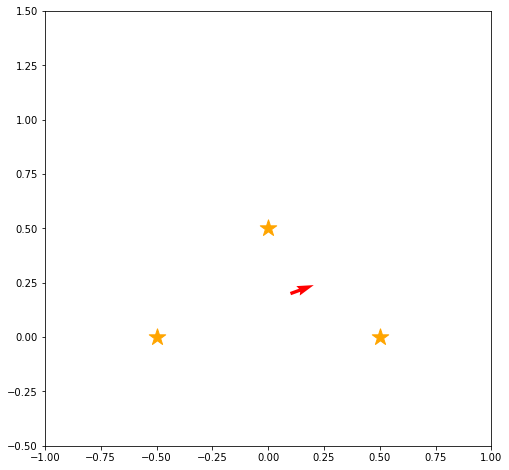

In [6]:
# 新規ウィンドウ、座標軸を用意
fig = plt.figure(figsize=(8, 8))
world = fig.add_subplot(1,1,1)
world.set_xlim(-1.0,1.0)
world.set_ylim(-0.5,1.5)

robot = Robot(np.array([0.1,0.2,np.deg2rad(20.0)]) )
robot.draw()
m.draw()
plt.show()

次に、「観測したランドマークがどの位置に見えているか」を示すための誤差楕円とロボットからランドマークまでの直線を描画します。

[[0.41391755811192793, -0.78075305464462885, 0.5, 0.0, 1], [0.3065530467691186, 1.639143491849405, 0.0, 0.5, 2]]


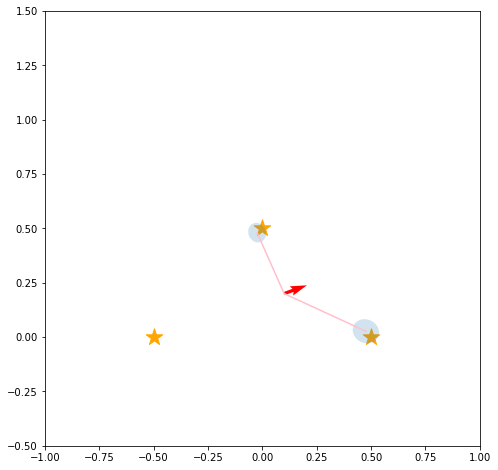

In [7]:
observations = robot.observation(m)
print(observations)

fig = plt.figure(0,figsize=(8, 8))
world = fig.add_subplot(111, aspect='equal')
world.set_xlim(-1.0,1.0)
world.set_ylim(-0.5,1.5)
    
for observation in observations:
    x,y,theta = robot.pose
    distance, direction,lx,ly, i = observation
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([robot.pose[0],  lx],[robot.pose[1],  ly],color="pink")
    
    c = math.cos(theta + direction)
    s = math.sin(theta + direction)
    rot = np.array([[c, -s],
                    [s,  c]])
    
    err_robot = np.array([[(distance*0.1)**2,0.0],
              [0.0,(distance*math.sin(np.deg2rad(5.0)))**2]])
    err_world = (rot).dot(err_robot).dot((rot).T)
    
    eig_vals,eig_vec = np.linalg.eig(err_world)
    v1 = eig_vals[0] * eig_vec[:,0]
    v2 = eig_vals[1] * eig_vec[:,1]
    v1_direction = math.atan2(v1[1],v1[0])
    
    elli = Ellipse([lx,ly],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=np.rad2deg(v1_direction))
    elli.set_alpha(0.2)
    world.add_artist(elli)
    
robot.draw()
m.draw()
plt.show()

# ランドマークの推定結果のためのクラス

ランドマークの推定結果を保存するためのクラスを用意します。構造体として使用します。

In [8]:
class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([[0.0],[0.0]])
        self.cov = np.array([[1000000000.0**2,0.0],
                            [0.0,1000000000.0**2]])    #最初は大きな共分散を持たせておく

# パーティクルのクラス

パーティクルに

* 重み
* ロボットの姿勢
* 地図

の3つの変数を持たせます。

動作をパーティクルに反映するための関数、計測値をパーティクルに反映するための関数、描画するための関数をメンバとして持ちます。

In [9]:
class Particle():
    def __init__(self,pose,w):
        self.w = w
        self.pose = pose
        self.map = [LandmarkEstimation(),LandmarkEstimation(),LandmarkEstimation()] #ランドマーク数は3で既知とする

    def motion_update(self, fw, rot, robot):
        self.pose = robot.motion_model(self.pose, fw, rot)
        
    def measurement_update(self, measurement):
        x,y,theta = self.pose
        distance, direction,lx,ly,i = measurement
        ln = self.map[i]
        lx = distance*math.cos(theta + direction) + x
        ly = distance*math.sin(theta + direction) + y
        
        ## 重みの更新
        delta = np.array([[x],[y]]) - np.array([[lx],[ly]])
        coef = 2*math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T.dot(np.linalg.inv(ln.cov))).dot(delta)
        self.w *= 1.0/coef * math.exp(inexp)
        
        ## 地図の書き換え
        z = np.array([[lx],[ly]])
        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[c, -s],
                        [s,  c]])
        err_robot = np.array([[(distance*0.1)**2,0.0],
                            [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)
        ln.cov = np.linalg.inv( np.linalg.inv(ln.cov) + np.linalg.inv(err_world) )
        K = (ln.cov).dot(np.linalg.inv(err_world))
        ln.pos += K.dot( z - ln.pos )
        
    def draw(self,i):
        fig = plt.figure(i,figsize=(4, 4))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        m.draw()
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
        for e in self.map:
            eig_vals,eig_vec = np.linalg.eig(e.cov)
            v1 = eig_vals[0] * eig_vec[:,0]
            v2 = eig_vals[1] * eig_vec[:,1]
            v1_direction = math.atan2(v1[1],v1[0])

            x,y = e.pos
            elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
            elli.set_alpha(0.5)
        
            sp.add_artist(elli)

# FastSLAMクラス

パーティクル群を変数として持ち、動作をパーティクルに反映するための関数、計測値をパーティクルに反映するための関数、リサンプリングのための関数をメンバとして持ちます。

In [10]:
import copy
        
class FastSLAM():
    def __init__(self,pose):
        self.particles = [Particle(pose,1.0/100) for i in range(100)]
        
    def draw(self):
        for (i, p) in enumerate(self.particles):
            p.draw(i)
            if i > 3: return  # 一部のパーティクルのみ描画
            
    def motion_update(self, fw, rot, robot):
        for p in self.particles:
            p.motion_update(fw,rot, robot)
            
    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)
            
        self.resampling()
            
    def resampling(self):
        num = len(self.particles)  # パーティクルの個数
        ws = [e.w for e in self.particles]    # 重みのリストを作る
    
        if sum(ws) < 1e-100:  # 重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
            ws = [e + 1e-100 for e in ws]
            
        ps = random.choices(self.particles, weights=ws, k=num)    # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ
        self.particles = [copy.deepcopy(e) for e in ps]  # 選んだリストからパーティクルを取り出し、パーティクルの姿勢から重み1/numの新しいパーティクルを作成

実行します。初期状態では各ランドマークの推定の共分散が大きく、位置を具体的に定めることができていません。

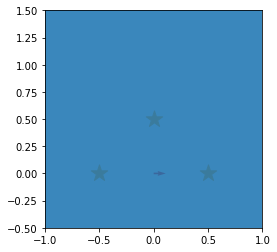

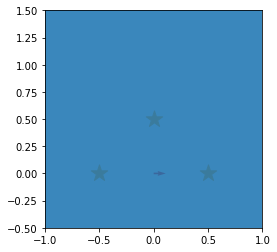

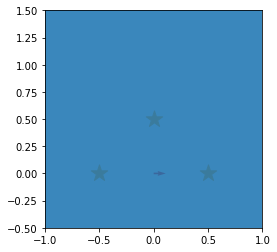

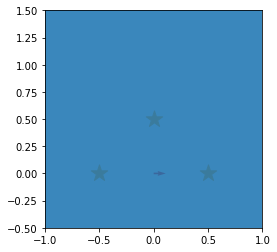

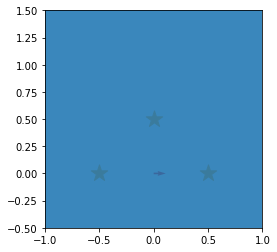

In [11]:
robot.pose = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
slam = FastSLAM(robot.pose)
slam.draw()
plt.show()

### 青いのは画像からはみ出た誤差楕円の色です。 ###

10ステップ後、20ステップ後、30ステップ後、40ステップ後のパーティクルを描画します。

推定の誤差楕円がだんだん小さくなっていくことが確認できます。

10step後の地図


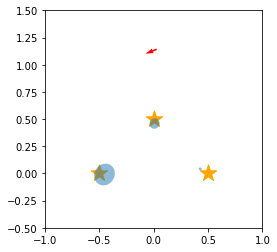

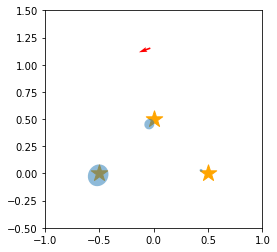

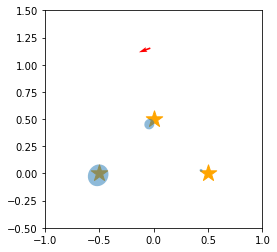

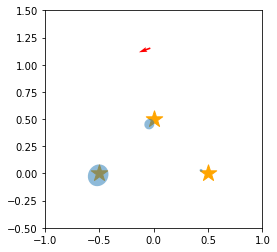

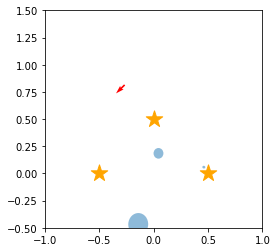

20step後の地図


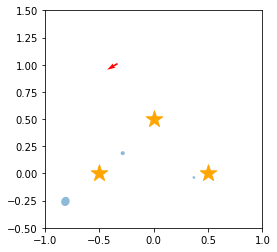

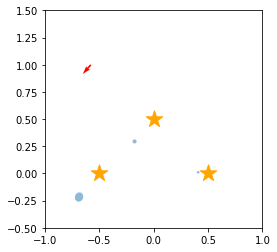

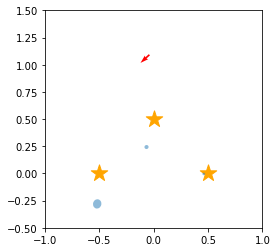

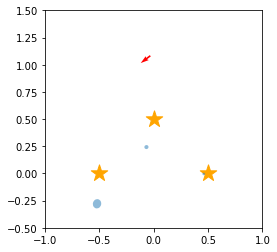

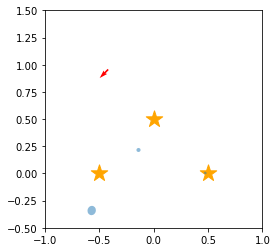

30step後の地図


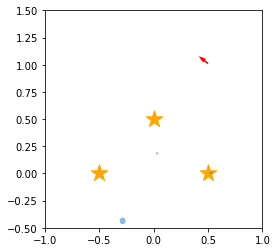

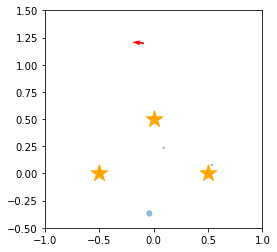

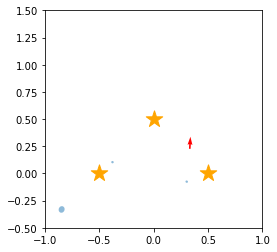

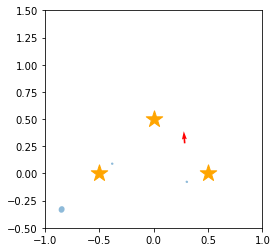

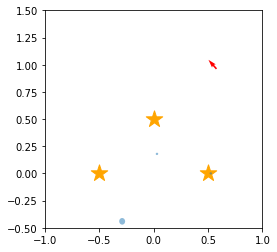

40step後の地図


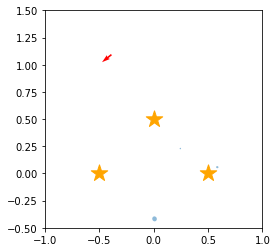

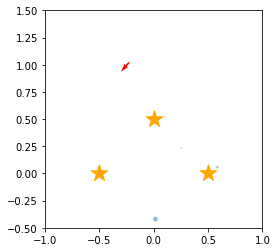

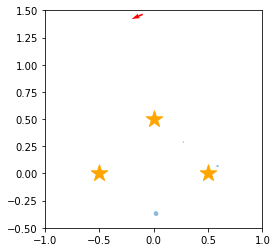

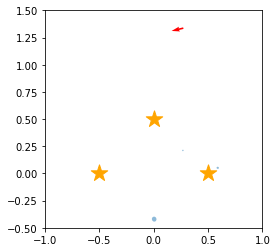

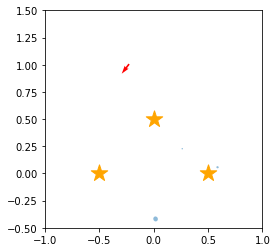

In [12]:
def one_step(m):
    slam.motion_update(0.2, np.deg2rad(20.0), robot)
    robot.pose = robot.motion_model(robot.pose, 0.2, np.deg2rad(20.0))
    measurements = robot.observation(m)
    for m in measurements:
        slam.measurement_update(m)

n = 10
for loop in range(1, 5):
    for i in range(loop * n):
        one_step(m)

    print(str(loop * n) + "step後の地図")
    slam.draw()
    plt.show()